In [1]:
# %matplotlib inline
from numpy.random import RandomState
import numpy
import re
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, multilabel_confusion_matrix
from sklearn.multiclass import OneVsRestClassifier
from nltk.corpus import stopwords
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import seaborn as sns
import string
from sklearn.decomposition import TruncatedSVD

In [2]:
import os
path_to_model = 'C:/Users/prana/Desktop/BE Project/LegalBuddyServer/OPPClassifiers/SecondaryClassifiers/Models/ThirdPartySharing/Purpose.sav'
# os.listdir(path_to_model)

# Create Multilabel Dataset

In [3]:
#preprocess
df = pd.read_csv('dataset.csv')
df = df.dropna()

classes = list(df.Category.unique())
total_unique_clauses = df.Clause.unique().size

#creating dict for appending
classes_dict = {}
for single_class in classes:
    classes_dict[single_class] = list(numpy.zeros(total_unique_clauses))

#creating the df
data = {}
for index,row in df.iterrows():
    try : 
        data[row['Clause']].append(row['Category'])
        data[row['Clause']] = list(set(data[row['Clause']]))  
    except:
        data[row['Clause']] = [row['Category']]

        Clause = []
Category = []
for key in data.keys():
    Clause.append(key)
    Category.append(data[key])
    
data = pd.DataFrame({
    'Clause' : Clause,
    'Category' : Category
})
index = 0
for category_list in data.Category:
    for category in category_list:
        classes_dict[category][index] = 1
    index += 1

classes_dict = pd.DataFrame(classes_dict)

In [4]:
data.head()

,Clause,Category
0,We may from time to time use your personally i...,[Unspecified]
1,"analyze data,",[Analytics/Research]
2,process transactions,[Basic service/feature]
3,"participate in or administer our promotions, s...",[Additional service/feature]
4,provide marketing or promotional assistance or...,[Marketing]


In [5]:
classes_dict.head()

,Unspecified,Analytics/Research,Basic service/feature,Additional service/feature,Marketing,Advertising,Service operation and security,Merger/Acquisition,Legal requirement,Other,Personalization/Customization
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
one_hot_encoded_data = pd.concat([data, classes_dict], axis=1)
one_hot_encoded_data.drop(columns=['Category']).to_csv('multilabel_dataset.csv')

In [7]:
df = pd.read_csv('multilabel_dataset.csv')
df = df.dropna()
train = df.sample(frac=0.8, random_state = RandomState())
test = df.loc[~df.index.isin(train.index)]
validation = train.sample(frac=0.2, random_state=200)

In [8]:
df.columns.values[2:]

array(['Unspecified', 'Analytics/Research', 'Basic service/feature',
       'Additional service/feature', 'Marketing', 'Advertising',
       'Service operation and security', 'Merger/Acquisition',
       'Legal requirement', 'Other', 'Personalization/Customization'],
      dtype=object)

# Visualizing Data

In [9]:
counts = []
categories = list(df.columns.values[2:])
for i in categories:
    counts.append((i, df[i].sum()))
df_stats = pd.DataFrame(counts, columns=['category', 'number_of_comments'])
df_stats

,category,number_of_comments
0,Unspecified,541.0
1,Analytics/Research,254.0
2,Basic service/feature,393.0
3,Additional service/feature,309.0
4,Marketing,251.0
5,Advertising,376.0
6,Service operation and security,328.0
7,Merger/Acquisition,190.0
8,Legal requirement,314.0
9,Other,158.0


Text(0.5, 0, 'category')

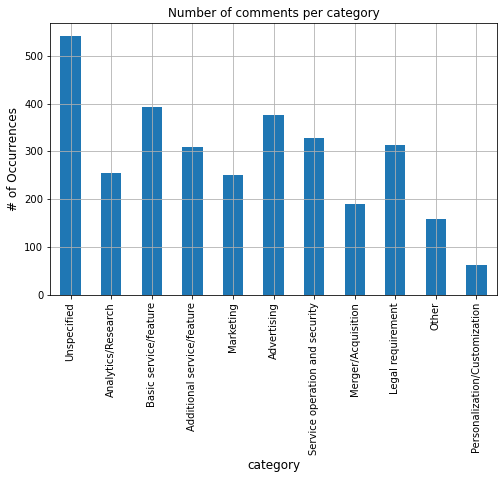

In [10]:
df_stats.plot(x='category', y='number_of_comments', kind='bar', legend=False, grid=True, figsize=(8, 5))
plt.title("Number of comments per category")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('category', fontsize=12)

# Preprocessing Data

In [11]:
# cleaned_clause = []
# for clause in df.Clause:
#     clause = clause.lower()
#     clause = re.sub(r'[0-9]+', '',clause) #number removal
#     clause = clause.translate(string.maketrans(“”,””), string.punctuation) #removinf punctuations
#     clause = clause.strip() #whitespace removal
#     clause
#     break

In [12]:
x_test = test.Clause
x_train = train.Clause

In [13]:
y = train.iloc[:,2:]
y_test = test.iloc[:,2:]

categories = list(y.columns)

In [14]:
tfidf = TfidfVectorizer()
tfidf.fit_transform(df.Clause)

<3112x2893 sparse matrix of type '<class 'numpy.float64'>'
	with 51083 stored elements in Compressed Sparse Row format>

# Naive Bayes

In [15]:
prediction_pd = {}
classifier_list_nb = []
for category in categories:
    clf = OneVsRestClassifier(MultinomialNB(fit_prior=True, class_prior=None))
    print('... Processing {}'.format(category))
    clf.fit(tfidf.transform(x_train), y[category])
    prediction = clf.predict(tfidf.transform(x_test))
    print('Test accuracy is {}'.format(accuracy_score(y_test[category], prediction)))
    prediction_pd[category] = prediction
    classifier_list_nb.append(clf)
prediction_pd = pd.DataFrame(prediction_pd)
multilabel_confusion_matrix(y_test, prediction_pd)

... Processing Unspecified
Test accuracy is 0.8810289389067524
... Processing Analytics/Research
Test accuracy is 0.9163987138263665
... Processing Basic service/feature
Test accuracy is 0.8890675241157556
... Processing Additional service/feature
Test accuracy is 0.8987138263665595
... Processing Marketing
Test accuracy is 0.9147909967845659
... Processing Advertising
Test accuracy is 0.9196141479099679
... Processing Service operation and security
Test accuracy is 0.9147909967845659
... Processing Merger/Acquisition
Test accuracy is 0.9694533762057878
... Processing Legal requirement
Test accuracy is 0.9726688102893891
... Processing Other
Test accuracy is 0.9501607717041801
... Processing Personalization/Customization
Test accuracy is 0.9790996784565916


array([[[513,   6],
        [ 68,  35]],

       [[565,   0],
        [ 52,   5]],

       [[549,   0],
        [ 69,   4]],

       [[556,   0],
        [ 63,   3]],

       [[569,   0],
        [ 53,   0]],

       [[556,   0],
        [ 50,  16]],

       [[554,   2],
        [ 51,  15]],

       [[582,   0],
        [ 19,  21]],

       [[556,   0],
        [ 17,  49]],

       [[591,   0],
        [ 31,   0]],

       [[609,   0],
        [ 13,   0]]], dtype=int64)

# Linear SVC

In [16]:
prediction_pd = {}
classifier_list_svc = []
clf = OneVsRestClassifier(LinearSVC(), n_jobs=1)
for category in categories:
    print('... Processing {}'.format(category))
    clf.fit(tfidf.transform(x_train), y[category])
    prediction = clf.predict(tfidf.transform(x_test))
    print('Test accuracy is {}'.format(accuracy_score(y_test[category], prediction)))
    prediction_pd[category] = prediction
    classifier_list_svc.append(clf)
prediction_pd = pd.DataFrame(prediction_pd)
multilabel_confusion_matrix(y_test, prediction_pd)

... Processing Unspecified
Test accuracy is 0.9067524115755627
... Processing Analytics/Research
Test accuracy is 0.9662379421221865
... Processing Basic service/feature
Test accuracy is 0.9147909967845659
... Processing Additional service/feature
Test accuracy is 0.9147909967845659
... Processing Marketing
Test accuracy is 0.9662379421221865
... Processing Advertising
Test accuracy is 0.9807073954983923
... Processing Service operation and security
Test accuracy is 0.9372990353697749
... Processing Merger/Acquisition
Test accuracy is 0.9919614147909968
... Processing Legal requirement
Test accuracy is 0.9790996784565916
... Processing Other
Test accuracy is 0.9501607717041801
... Processing Personalization/Customization
Test accuracy is 0.9871382636655949


array([[[492,  27],
        [ 31,  72]],

       [[560,   5],
        [ 16,  41]],

       [[538,  11],
        [ 42,  31]],

       [[548,   8],
        [ 45,  21]],

       [[562,   7],
        [ 14,  39]],

       [[552,   4],
        [  8,  58]],

       [[541,  15],
        [ 24,  42]],

       [[582,   0],
        [  5,  35]],

       [[554,   2],
        [ 11,  55]],

       [[588,   3],
        [ 28,   3]],

       [[608,   1],
        [  7,   6]]], dtype=int64)

# Logistic Regression

In [17]:
prediction_pd = {}
classifier_list_lr = []
clf = OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=1)
for category in categories:
    print('... Processing {}'.format(category))
    clf.fit(tfidf.transform(x_train), y[category])
    prediction = clf.predict(tfidf.transform(x_test))
    print('Test accuracy is {}'.format(accuracy_score(y_test[category], prediction)))
    prediction_pd[category] = prediction
    classifier_list_lr.append(clf)
prediction_pd = pd.DataFrame(prediction_pd)
multilabel_confusion_matrix(y_test, prediction_pd)

... Processing Unspecified
Test accuracy is 0.9019292604501608
... Processing Analytics/Research
Test accuracy is 0.9340836012861736
... Processing Basic service/feature
Test accuracy is 0.9035369774919614
... Processing Additional service/feature
Test accuracy is 0.905144694533762
... Processing Marketing
Test accuracy is 0.9501607717041801
... Processing Advertising
Test accuracy is 0.9598070739549839
... Processing Service operation and security
Test accuracy is 0.932475884244373
... Processing Merger/Acquisition
Test accuracy is 0.9790996784565916
... Processing Legal requirement
Test accuracy is 0.9726688102893891
... Processing Other
Test accuracy is 0.9501607717041801
... Processing Personalization/Customization
Test accuracy is 0.9790996784565916


array([[[509,  10],
        [ 51,  52]],

       [[564,   1],
        [ 40,  17]],

       [[547,   2],
        [ 58,  15]],

       [[555,   1],
        [ 58,   8]],

       [[568,   1],
        [ 30,  23]],

       [[554,   2],
        [ 23,  43]],

       [[554,   2],
        [ 40,  26]],

       [[582,   0],
        [ 13,  27]],

       [[555,   1],
        [ 16,  50]],

       [[591,   0],
        [ 31,   0]],

       [[609,   0],
        [ 13,   0]]], dtype=int64)

In [18]:
import pickle
#saving model
list_of_classifiers = classifier_list_svc
pickle.dump((tfidf, list_of_classifiers), open(path_to_model, 'wb'))

In [17]:
with open(path_to_model, 'rb') as model:
    vect, clfs = pickle.load(model)

In [16]:
clfs

[OneVsRestClassifier(estimator=LogisticRegression(C=1.0, class_weight=None,
                                                  dual=False, fit_intercept=True,
                                                  intercept_scaling=1,
                                                  l1_ratio=None, max_iter=100,
                                                  multi_class='auto',
                                                  n_jobs=None, penalty='l2',
                                                  random_state=None,
                                                  solver='sag', tol=0.0001,
                                                  verbose=0, warm_start=False),
                     n_jobs=1),
 OneVsRestClassifier(estimator=LogisticRegression(C=1.0, class_weight=None,
                                                  dual=False, fit_intercept=True,
                                                  intercept_scaling=1,
                                                  l1_ratio=